# Clustering - Introduction
This notebook is a third part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository meant to cluster the playlist and track information from the [eargasm music channel](https://open.spotify.com/user/eargasmusic?si=HtTLbkG6QoqkdKU3uTRjAQ) at Spotify.

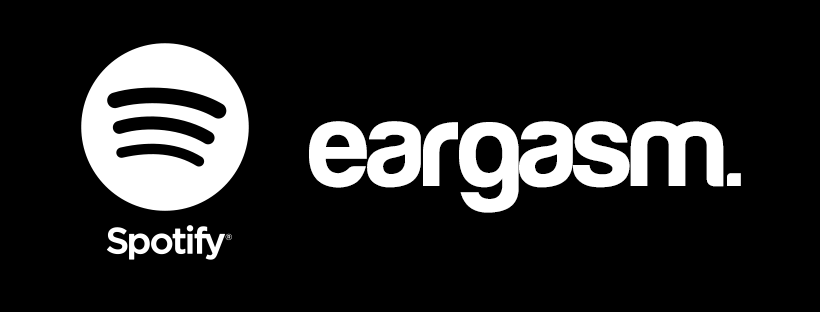

# Set up environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


In [3]:
!ls

catboost_info		      eargasm_DataExploration.ipynb  files
eargasm_Classification.ipynb  eargasm_DataRetrieval.ipynb    README.md


In [4]:
!pip install category_encoders

## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars

In [5]:
from tqdm.notebook import tqdm

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [6]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [7]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

## Machine learning

In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
# import category_encoders as ce 


# Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [9]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,42,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


# Feature extraction

# Feature engineering

In [10]:
features_to_keep = [
                    # 'track_artist',
                    'track_duration',
                    'track_popularity',
                    # 'track_releasedate',
                    'track_genre',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'key',
                    # 'key_confidence',
                    'mode',
                    # 'mode_confidence',
                    # 'number_of_sections',
                    'tempo',
                    # 'tempo_confidence',
                    'time_signature',
                    # 'time_signature_confidence',
                    'track_playlist'
                    ]
df_encoded = final_df[features_to_keep]

## Functions

In [11]:
def cut_into_categories(feature_name, number_of_categories):

  df_encoded[feature_name] = final_df[feature_name]  
  df_encoded[feature_name] = pd.cut(df_encoded[feature_name], number_of_categories)

  ranges = df_encoded[feature_name].unique()
  ranges.sort_values(inplace=True)

  for n, value in enumerate(ranges):
    df_encoded.loc[df_encoded[feature_name] == value, feature_name+'_en'] = n+1

  df_encoded.drop(columns=[feature_name], inplace=True)
  df_encoded.rename(columns = {feature_name+'_en': feature_name}, inplace = True)

  return df_encoded

In [12]:
def fill_nans(feature_name):
  df_encoded[feature_name].fillna(int(df_encoded[feature_name].mean()), inplace=True)
  return df_encoded

## `track_duration`

In [13]:
df_encoded['track_duration'] = final_df['track_duration'] # reset value
df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)

cut_into_categories('track_duration', 10)
cut_into_categories('track_popularity', 10)
cut_into_categories('acousticness', 10)
cut_into_categories('danceability', 10)
cut_into_categories('energy', 10)
cut_into_categories('instrumentalness', 10)
cut_into_categories('liveness', 10)
cut_into_categories('speechiness', 10)
cut_into_categories('valence', 10)
cut_into_categories('tempo', 15)

df_encoded['track_genre'].fillna('unknown', inplace=True)
df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)


fill_nans('key')
fill_nans('mode')
fill_nans('time_signature')

df_encoded = df_encoded.dropna()
df_encoded.head()

,track_genre,key,mode,time_signature,track_playlist,track_duration,track_popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo
0,unknown,9.0,0.0,4.0,eargasm | breathe easy,4.0,6.0,4.0,5.0,5.0,3.0,1.0,1.0,4.0,4.0
1,alternative country,7.0,0.0,4.0,eargasm | breathe easy,4.0,7.0,4.0,7.0,6.0,1.0,4.0,1.0,8.0,5.0
2,vapor pop,1.0,1.0,4.0,eargasm | breathe easy,3.0,1.0,2.0,6.0,8.0,9.0,2.0,1.0,7.0,4.0
3,unknown,11.0,1.0,4.0,eargasm | breathe easy,3.0,1.0,8.0,7.0,6.0,1.0,1.0,2.0,4.0,7.0
4,alternative americana,0.0,1.0,4.0,eargasm | breathe easy,4.0,7.0,3.0,5.0,6.0,1.0,2.0,1.0,6.0,10.0


# Preprocessing

## Classification with probabilities

In [28]:
X = df_encoded[['track_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo']]
y = df_encoded['track_playlist']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [30]:
from sklearn import svm

clf = make_pipeline(StandardScaler(), svm.SVC(gamma='auto', probability=True))
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.18763796909492272

In [83]:
def probabilities(number):
  df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
  df = df.sort_values(by='probability', ascending=False).head(n=3)

  index_number = X_test.index[number]
  prediction = clf.predict(X_test)[number], final_df.loc[index_number]['track_url']

  id = final_df.loc[index_number]['track_id']
  truth = final_df.loc[final_df['track_id'] == id]['track_playlist']
  return print('Prediction: \n {}\n\n Probabilities: \n {}\n\n Truth: {}'.format(prediction, df, truth))

In [85]:
random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

Prediction: 
 ('eargasm | organised noise', 'https://open.spotify.com/track/3sdLbza2Dux2AIp3BXjSZL')

 Probabilities: 
                              class  probability
18              eargasm | polymers     0.132991
16       eargasm | organised noise     0.116453
9   eargasm | high frequency radio     0.088042

 Truth: 746        eargasm | curvatronik
747    eargasm | organised noise
748           eargasm | polymers
Name: track_playlist, dtype: object


## Multilabel classification
https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value/45088911

In [22]:
# columns = final_df.columns.to_list()
# columns.remove('track_playlist')

columns = [
           'track_id',
           'track_url',
           'acousticness',
           'danceability',
           'instrumentalness',
           'valence',
           'tempo',
           'track_duration',
           'track_popularity',
           'track_playlist'
          ]

# df_nodup = final_df.copy()
df = final_df.copy()[columns]

df = df.groupby(['track_id', 'track_url', 'acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']).agg(list).reset_index()
df.head()



,track_id,track_url,acousticness,danceability,instrumentalness,valence,tempo,track_duration,track_popularity,track_playlist
0,00KZS85QPRD8dKcwPBvBLI,https://open.spotify.com/track/00KZS85QPRD8dKc...,0.00944,0.541,0.941,0.0772,124.010,462580,0,"[eargasm | curvatronik, eargasm | get moving, ..."
1,00bz5bGRGFMfACJWfhMSxx,https://open.spotify.com/track/00bz5bGRGFMfACJ...,0.42800,0.443,0.864,0.2450,105.025,306720,58,[eargasm | on top]
2,00dBPNbvFCu5tP2nOqDRYE,https://open.spotify.com/track/00dBPNbvFCu5tP2...,0.19500,0.674,0.860,0.5020,119.982,416380,35,[eargasm | curvatronik]
3,00nZjMB2Ts8Vy1OX7b6Jnh,https://open.spotify.com/track/00nZjMB2Ts8Vy1O...,0.35900,0.541,0.597,0.0383,107.962,423239,42,[eargasm | solitary confinement]
4,01Ak1rLiH9FZdOpmrX010T,https://open.spotify.com/track/01Ak1rLiH9FZdOp...,0.01020,0.695,0.701,0.4240,121.031,218918,29,[eargasm | neon socks]


In [23]:
X = df.drop(columns=['track_id', 'track_playlist', 'track_url'])
y = df['track_playlist']

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(y), columns=mlb.classes_)

# y_converted = mlb.fit_transform(y)
# y_converted
y

,eargasm | breathe easy,eargasm | city walk,eargasm | curvatronik,eargasm | decadency,eargasm | deep water,eargasm | departure,eargasm | dust settling,eargasm | get moving,eargasm | glide,eargasm | high frequency radio,eargasm | into the wild,eargasm | joyride,eargasm | kickin' it ol' skool,eargasm | loungin',eargasm | neon socks,eargasm | on top,eargasm | organised noise,eargasm | oscilloscope,eargasm | polymers,eargasm | ptsd,eargasm | sky gazing,eargasm | sleepwalking,eargasm | solitary confinement,eargasm | space odyssey,eargasm | sunny days,eargasm | swimming pool sunset,eargasm | warm up,eargasm | we up all night,eargasm | weightless
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2357,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2358,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2359,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [26]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
# # cross_val_score(clf, X_test, y_test, cv=10).mean()


In [27]:
y_pred = pd.Series(mlb.inverse_transform(clf.predict(X_test)))
y_pred[530]


ValueError: ignored

In [ ]:
X_test.iloc[520]

In [ ]:
index_number = X_test.index[520]
index_number

In [ ]:
df.loc[index_number]['track_url']

In [ ]:
def check_multilabel(number):
  # index_number = X_test.index[590]
  # pl_names = y_test.columns
  # mask = clf.predict(X_test)[590].astype(bool)
  # id = df.loc[index_number]['track_id']
  # preds = pl_names[mask]
  # url = final_df.loc[final_df['track_id'] == '7pHujzt4Naoo4czUgxBQyr']['track_url']
  return print(preds, url)

In [ ]:
check_multilabel(590)

## Multi output

In [ ]:
X = df_encoded[['acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']]
y = df_encoded['track_playlist']

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
# mlb.classes_

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)

# Y_train = mlb.fit_transform(y_train)
# Y_test = mlb.fit_transform(y_test)
# Y_train[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.predict_proba(X_test)

## Shit

In [ ]:
# X = df_encoded.drop('track_playlist', axis='columns')
# y = df_encoded['track_playlist']

In [ ]:
# ordinal_categories = [
#                       'track_duration',
#                       'track_popularity',
#                       'acousticness',
#                       'danceability',
#                       'energy',
#                       'instrumentalness',
#                       'liveness',
#                       'speechiness',
#                       'valence',
#                       'tempo'
#                      ]

# nominal_categories = [
#                       'track_genre',
#                       'key',
#                       'mode',
#                       'time_signature'
#                      ]
# column_transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), nominal_categories),
#     remainder='passthrough'
#     )
# column_transformer.fit_transform(X)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()

In [ ]:
# pipe = make_pipeline(column_transformer, knn)

In [ ]:
# cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(X_encoded[['track_genre']]).shape
# ohe.categories_
# # pe = OrdinalEncoder()



In [ ]:
# encoder = ce.BinaryEncoder(cols=['track_artist', 'track_genre'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# X_encoded['track_duration'] = X_encoded['track_duration'].apply(lambda x: int(x/1000))

# X_encoded['tempo'].fillna(X_encoded['tempo'].mean(), inplace=True)
# X_encoded['tempo'] = X_encoded['tempo'].apply(lambda x: int(x))
# X_encoded.head()

In [ ]:
# X_encoded['track_releasedate_year'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).year)
# X_encoded['track_releasedate_month'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).month)
# X_encoded.drop(columns=['track_releasedate'], inplace=True)
# X_encoded.head()

In [ ]:
# encoder = ce.OneHotEncoder(cols=['key', 'mode', 'number_of_sections', 'time_signature'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# features=['key', 'mode', 'tempo', 'time_signature']
# for feat in features:
#   X_encoded[feat].fillna(X_encoded[feat].mean(), inplace=True)

# References
- https://contrib.scikit-learn.org/category_encoders/
- https://www.datacamp.com/community/tutorials/categorical-data
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- https://opendatascience.com/a-machine-learning-deep-dive-into-my-spotify-data/
- https://www.kaggle.com/lowkimhoe/prediction-model-on-spotify-classification